<a href="https://colab.research.google.com/github/malickl/CNN_projet/blob/main/Copie_de_Projet_CN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Monte ton Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extraction du dataset depuis le zip
zip_path = '/content/drive/MyDrive/malaria_hematie_dataset.zip'
extract_dir = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# Répertoire contenant les images organisées par classe
# (Par exemple, extract_dir/malaria_hematie_dataset/parasitized et extract_dir/malaria_hematie_dataset/uninfected)
data_dir = os.path.join(extract_dir, 'malaria_hematie_dataset')

# 1. Création d'un DataFrame listant le chemin de chaque image et son label
data = []
classes = ['parasitized', 'uninfected']
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            data.append({'filepath': os.path.join(class_dir, filename), 'label': class_name})
df = pd.DataFrame(data)
print("Nombre total d'images :", len(df))
print(df.head())

Nombre total d'images : 27558
                                            filepath        label
0  /content/dataset/malaria_hematie_dataset/paras...  parasitized
1  /content/dataset/malaria_hematie_dataset/paras...  parasitized
2  /content/dataset/malaria_hematie_dataset/paras...  parasitized
3  /content/dataset/malaria_hematie_dataset/paras...  parasitized
4  /content/dataset/malaria_hematie_dataset/paras...  parasitized


In [ ]:
# 2. Séparation du DataFrame en train (60%), validation (20%) et test (20%)
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify=train_val_df['label'])

In [ ]:
print("Ensemble d'entraînement :", len(train_df))
print("Ensemble de validation :", len(val_df))
print("Ensemble de test :", len(test_df))

Ensemble d'entraînement : 16534
Ensemble de validation : 5512
Ensemble de test : 5512


In [ ]:
# 3. Création des générateurs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Pour validation et test, on fait le rescale
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

target_size = (64, 64)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Pour conserver l'ordre lors de l'évaluation
)

Found 16534 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.


In [ ]:
# 4. Définition des callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)
lr_decay = LearningRateScheduler(scheduler)

In [ ]:
# 5. Définition des modèles
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50

In [ ]:
# Modèle from scratch
model = Sequential([

    Input(shape=(target_size[0], target_size[1], 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.20),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.20),

    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Modèle VGG16 fine-tuning
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

base_model_vgg.trainable = False

model_vgg = Sequential([
    base_model_vgg,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.20),
    Dense(1, activation='sigmoid')
])

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Modèle ResNet50 fine-tuning
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

base_model_resnet.trainable = False


model_resnet = Sequential([
    base_model_resnet,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.20),
    Dense(1, activation='sigmoid')
])

model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# 6. Entraînement des modèles
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[lr_decay, early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.6119 - loss: 0.6585 - val_accuracy: 0.7542 - val_loss: 0.5716 - learning_rate: 0.0010
Epoch 2/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy: 0.7578 - loss: 0.5566 - val_accuracy: 0.8373 - val_loss: 0.4097 - learning_rate: 0.0010
Epoch 3/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.8152 - loss: 0.4684 - val_accuracy: 0.9087 - val_loss: 0.3339 - learning_rate: 0.0010
Epoch 4/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.8279 - loss: 0.4349 - val_accuracy: 0.8587 - val_loss: 0.3694 - learning_rate: 0.0010
Epoch 5/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.8385 - loss: 0.4072 - val_accuracy: 0.9151 - val_loss: 0.2503 - learning_rate: 0.0010
Epoch 6/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.8631 - loss: 0.3658 - val_accuracy: 0.9162 - val_loss: 0.2369 - learning_rate: 9.0484e-04
Epoch 7/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 44s 85ms/step - accuracy: 0.8807

In [ ]:
history2 = model_vgg.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[lr_decay, early_stop],
    verbose=1
)

Epoch 1/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 58s 104ms/step - accuracy: 0.8143 - loss: 0.4040 - val_accuracy: 0.8895 - val_loss: 0.2598 - learning_rate: 0.0010
Epoch 2/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 49s 95ms/step - accuracy: 0.8695 - loss: 0.3141 - val_accuracy: 0.9113 - val_loss: 0.2198 - learning_rate: 0.0010
Epoch 3/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.8752 - loss: 0.2995 - val_accuracy: 0.9187 - val_loss: 0.2069 - learning_rate: 0.0010
Epoch 4/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.8847 - loss: 0.2873 - val_accuracy: 0.9220 - val_loss: 0.2086 - learning_rate: 0.0010
Epoch 5/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.8841 - loss: 0.2882 - val_accuracy: 0.9227 - val_loss: 0.2000 - learning_rate: 0.0010
Epoch 6/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.8886 - loss: 0.2750 - val_accuracy: 0.9189 - val_loss: 0.2054 - learning_rate: 9.0484e-04
Epoch 7/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 47s 91ms/step - accuracy: 0.885

In [ ]:
history3 = model_resnet.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[lr_decay, early_stop],
    verbose=1
)

Epoch 1/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.5753 - loss: 0.6880 - val_accuracy: 0.6515 - val_loss: 0.6480 - learning_rate: 0.0010
Epoch 2/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.6154 - loss: 0.6557 - val_accuracy: 0.6566 - val_loss: 0.6338 - learning_rate: 0.0010
Epoch 3/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 47s 91ms/step - accuracy: 0.6130 - loss: 0.6553 - val_accuracy: 0.5524 - val_loss: 0.6989 - learning_rate: 0.0010
Epoch 4/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step - accuracy: 0.6191 - loss: 0.6524 - val_accuracy: 0.5967 - val_loss: 0.6572 - learning_rate: 0.0010
Epoch 5/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.6276 - loss: 0.6490 - val_accuracy: 0.6308 - val_loss: 0.6308 - learning_rate: 0.0010
Epoch 6/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 94ms/step - accuracy: 0.6260 - loss: 0.6501 - val_accuracy: 0.6148 - val_loss: 0.6368 - learning_rate: 9.0484e-04
Epoch 7/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.64

In [ ]:
# 7. Sauvegarde des poids
model.save('model_from_scratch.h5')
model_vgg.save('model_vgg.h5')
model_resnet.save('model_resnet.h5')

Évaluation du modèle from scratch :
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step
Matrice de Confusion :
 [[2434  322]
 [  27 2729]]


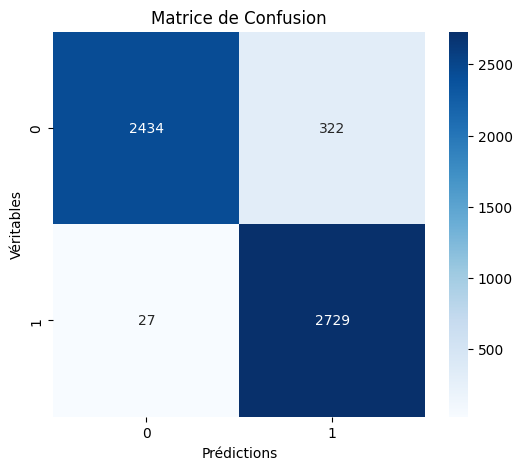

Accuracy        : 0.9366835994194485
Precision       : 0.8944608325139298
Recall          : 0.9902031930333817
F1 Score        : 0.9399001205441708
Spécificité     : 0.8831640058055152


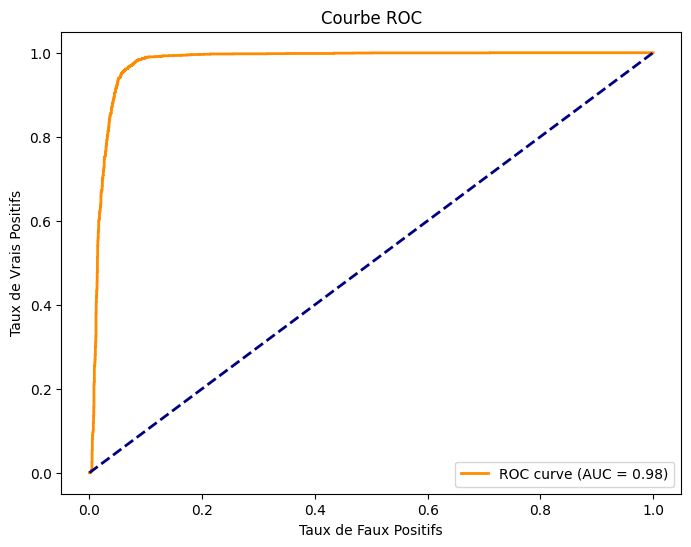

AUC             : 0.9774364837451892
Évaluation du modèle VGG16 :
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step
Matrice de Confusion :
 [[2522  234]
 [ 149 2607]]


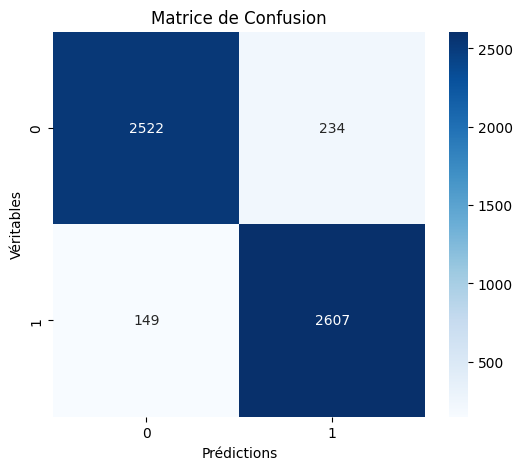

Accuracy        : 0.9305152394775036
Precision       : 0.9176346356916578
Recall          : 0.9459361393323658
F1 Score        : 0.9315704841879578
Spécificité     : 0.9150943396226415


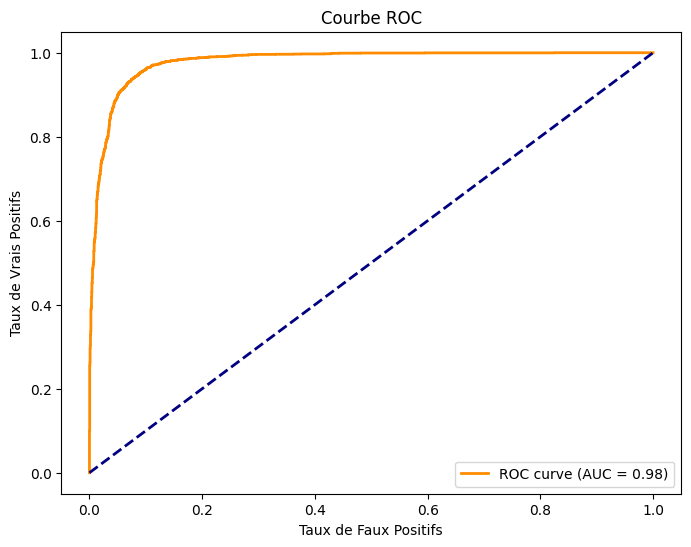

AUC             : 0.9787462662279528
Évaluation du modèle ResNet50 :
173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step
Matrice de Confusion :
 [[1430 1326]
 [ 446 2310]]


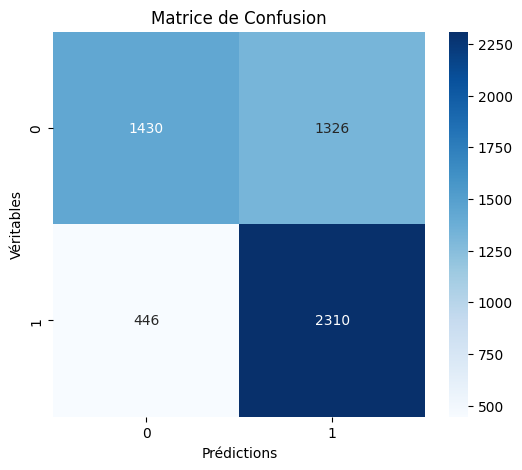

Accuracy        : 0.6785195936139332
Precision       : 0.6353135313531353
Recall          : 0.8381712626995645
F1 Score        : 0.7227784730913642
Spécificité     : 0.5188679245283019


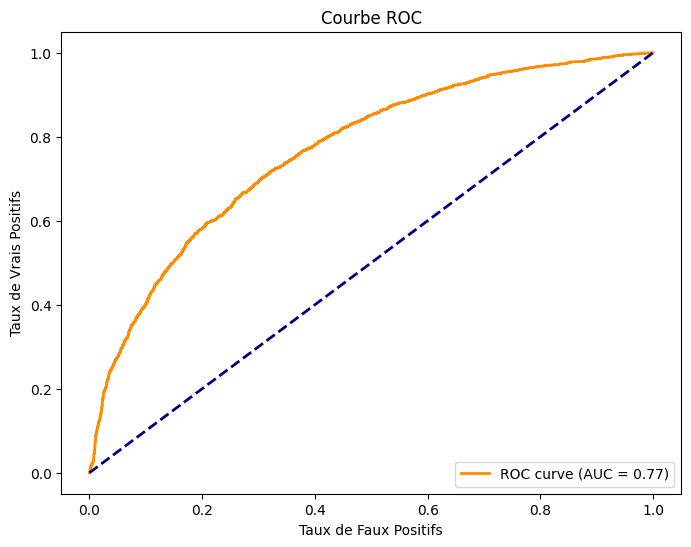

AUC             : 0.767412266889394


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_generator):
    y_pred_proba = model.predict(test_generator)
    y_pred = (y_pred_proba > 0.5).astype("int32").ravel()
    y_true = test_generator.classes

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    print("Matrice de Confusion :\n", cm)

    # Affichage de la matrice
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Prédictions")
    plt.ylabel("Véritables")
    plt.title("Matrice de Confusion")
    plt.show()

    # Calcul des métriques
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    specificity = TN / (TN + FP)

    print("Accuracy        :", accuracy)
    print("Precision       :", precision)
    print("Recall          :", recall)
    print("F1 Score        :", f1)
    print("Spécificité     :", specificity)

    # Courbe ROC et AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()

    print("AUC             :", roc_auc)

# Évaluation pour le modèle from scratch
print("Évaluation du modèle from scratch :")
evaluate_model(model, test_generator)

# Pour VGG16
print("Évaluation du modèle VGG16 :")
evaluate_model(model_vgg, test_generator)

# Pour ResNet50
print("Évaluation du modèle ResNet50 :")
evaluate_model(model_resnet, test_generator)
